### Investigate max durations outliers in student attempt times
The duration between student attempt start and stop times have large number of outliers of over 100 minutes

In [12]:
%%capture

%run '../lib/libraries.ipynb'
from ..lib import utilities as util
from pyspark.sql import functions as F

In [2]:
filterDf = util.load_df('filterDf')
types = util.get_var_types()

intVars = ['student_start_datetime',
             'student_stop_datetime',
             'scored_datetime',
             'item_attempt_start_datetime_utc',
             'item_attempt_end_datetime_utc']

###### Dataframe of positive values

In [3]:
posDf = filterDf.filter( F.col('student_duration_mins') >= 0 )
posDf.count()

64401

###### Display problem

In [4]:
posDf.select('student_duration_mins').toPandas().describe()

,student_duration_mins
count,64401.000000
mean,1339.521364
std,6329.121880
min,0.000000
25%,11.350000
50%,27.916667
75%,271.566667
max,261008.166667


- Max values over 260,000 above 3rd quartile

###### Histogram

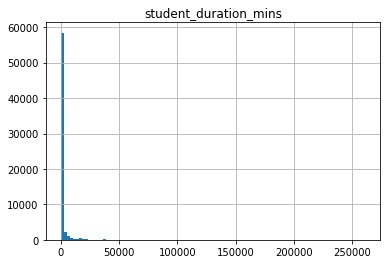

In [5]:
pdDf = posDf.select('student_duration_mins').toPandas()
ax = pdDf.hist(bins=100)

- Majority between 1 and 10
- Hard to visualize over 10

###### Histogram on logarithmic scale

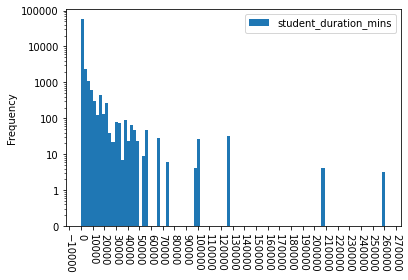

In [8]:
util.logrithmic_histogram(pdDf,10000)


- Steady before 50,000
- Outliers after 50,000

###### Scatter plot of duration vs dates

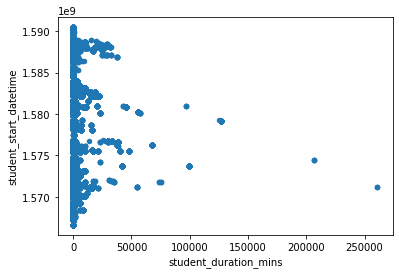

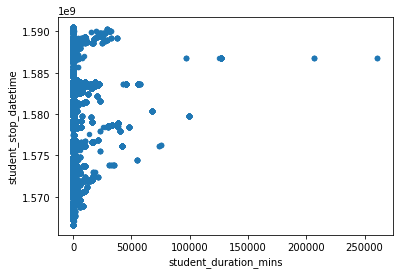

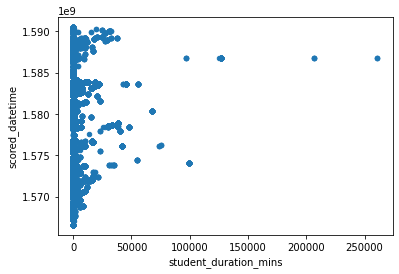

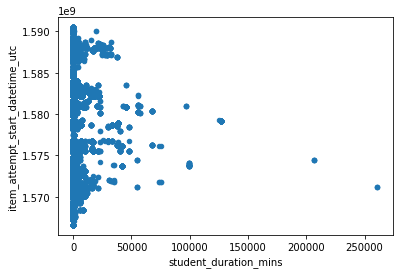

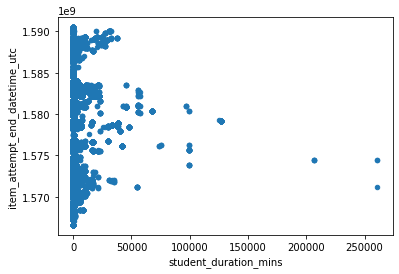

In [9]:
pdDf = posDf.select('student_duration_mins', * (F.unix_timestamp(c).alias(c) for c in intVars if c in posDf.columns) ).toPandas()

for c in intVars:
    ax = pdDf.plot('student_duration_mins', c, kind='scatter')

- Outliers visible
- Similar pattern between date variables
- Isolated instances above 50,000

###### Date boxplot of over 50,000

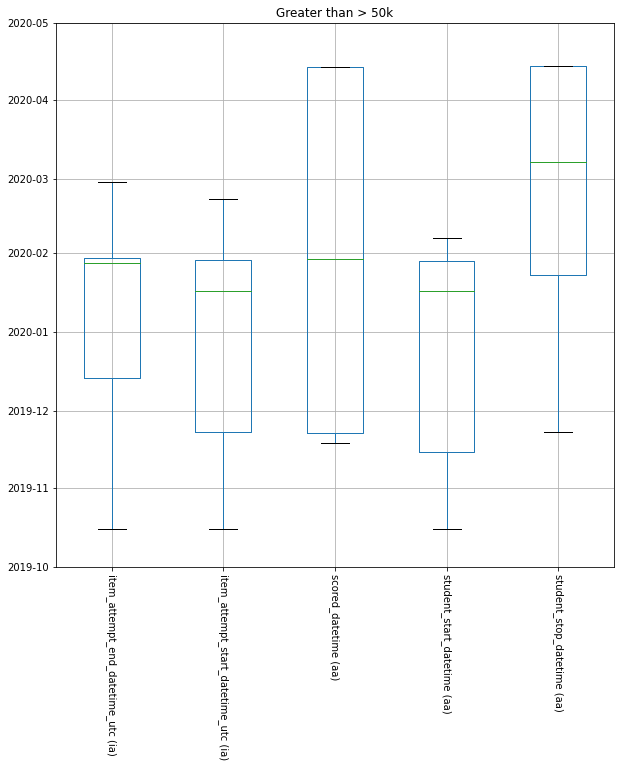

In [10]:
util.date_boxplot(posDf.filter( F.col('student_duration_mins') > 50000 ).select(*intVars), 'Greater than > 50k')

- stop dates 1/15 to 4/15
- scored 11/15 to 4/15


###### Detect Outliers by Interquartile Range
- Formula: (Q3 + 1.5 IQR)

In [13]:
(lowFilter, highFilter, median) = util.get_iqr_filter(posDf, 'student_duration_mins')
highFilter

661.8916666666667

- Outliers > 662

###### Create outlier dataset

In [14]:
outDf = posDf.filter( F.col('student_duration_mins') > highFilter)
print ('Count', outDf.count())
print ('Percentage', round(outDf.count() / posDf.count() * 100))

Count 13915
Percentage 22


- 13,915
- 22% of dataset

###### Check dates distribution

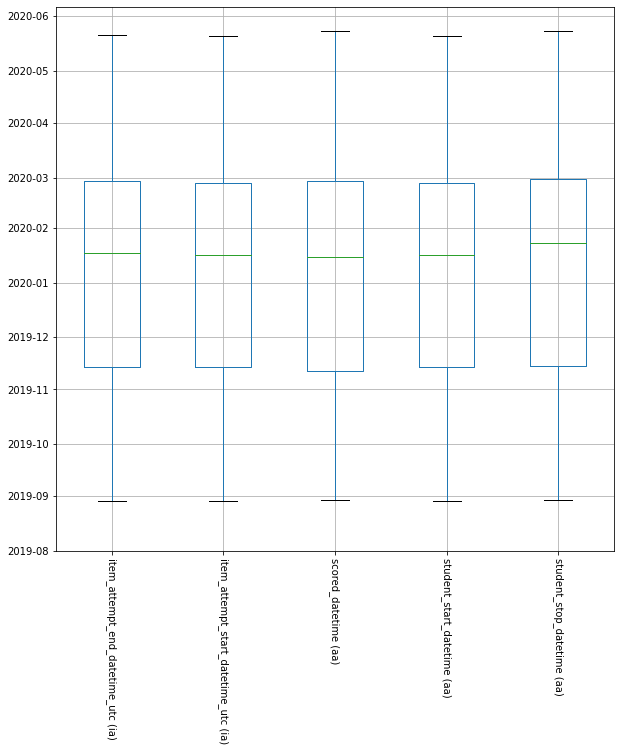

In [15]:
util.date_boxplot(outDf.select(*intVars), '')

- Median 1/15
- Majority between 11/15 to 3/1
  - Could be impacted by covid

##### Conclusion
- 22% of dataset has outliers
- Appear to be irregularity due to covid
- Impute with mean

###### Test Imputation

In [16]:
util.impute_student_duration(filterDf).select('student_duration_mins').toPandas().describe()

,student_duration_mins
count,64401.000000
mean,39.867542
std,81.242257
min,0.000000
25%,11.350000
50%,27.916667
75%,30.833333
max,653.033333


- Outliers resolved

In [17]:
util.finish_todo('Investigate max durations outliers in student attempt times')
util.add_todo('Impute max durations outliers in student attempt times')

Finished: Investigate max durations outliers in student attempt times
Todo: Impute max durations outliers in student attempt times
